C:\Users\sinha\AppData\Local\Temp\ipykernel_26892\1609017618.py:50: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\sinha\AppData\Local\Temp\ipykernel_26892\1609017618.py:131: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_26892\1609017618.py:131: DeprecationWarning: The class ``qiskit.primiti

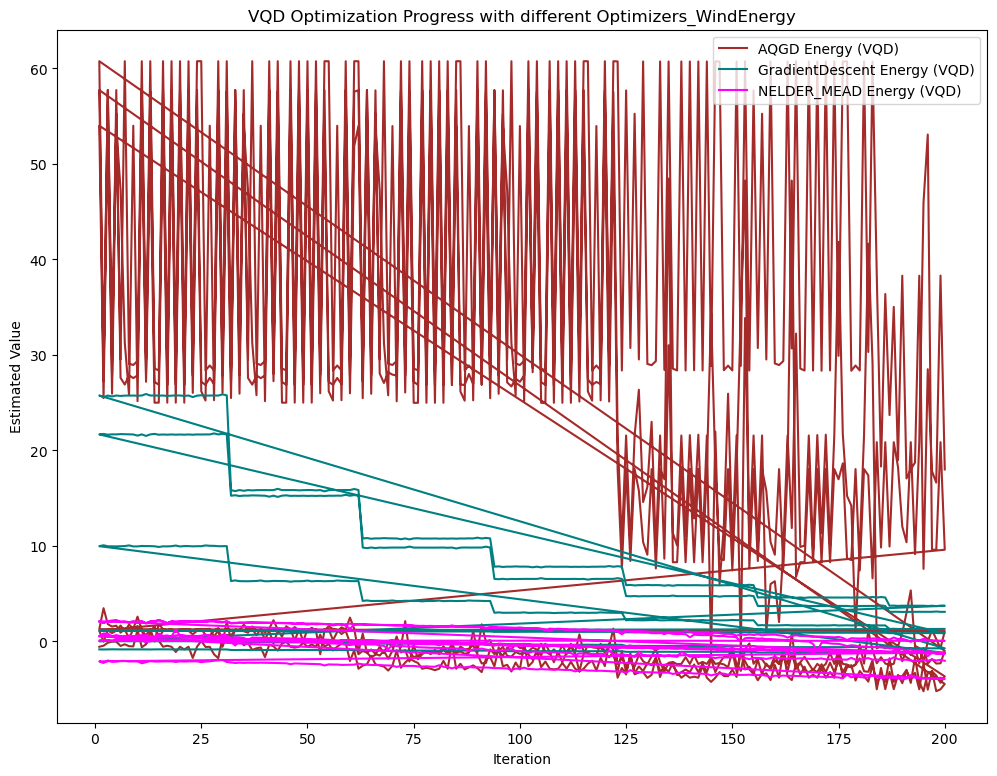


Maximum Value Details for Each Optimizer:
Optimizer: AQGD
Maximum Eigenvalue: 60.75755216942718
Data Point:
{'v': 0.6, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}
--------------------------------------------------
Optimizer: GradientDescent
Maximum Eigenvalue: 25.906595477187917
Data Point:
{'v': 1.7, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}
--------------------------------------------------
Optimizer: NELDER_MEAD
Maximum Eigenvalue: 2.245352456521704
Data Point:
{'v': 2.0, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}
--------------------------------------------------


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms import VQD
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import AQGD, GradientDescent, NELDER_MEAD
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import *
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute

# Read CSV file containing values of v, H, L, D_outer, D_inner, and d
csv_file_path = "E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
v_values = data['v'].values
H_values = data['H'].values
L_values = data['L'].values
D_outer_values = data['D_outer'].values
D_inner_values = data['D_inner'].values
d_values = data['d'].values

# Constants
eta = 0.3  # Efficiency
E = 70 * 10**9  # Young's modulus in Pascal
rho = 1.225  # Air density in kg/m^3
pi = np.pi

# Objective Function for Wind Turbine Power Output
def wind_power_output(v, H, L, D_outer, D_inner, d):
    numerator = eta * ((rho**2) * (v**5) * (D_outer**2) * (((H - (L / 2))**2) * (L**3)))
    denominator = 12 * E * ((pi / 64) * ((D_outer**4) - (D_inner**4)) * d)
    power = numerator / denominator
    return power

# Define the expanded Pauli operator based on the wind turbine objective function
v_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 
H_operator = SparsePauliOp.from_list([("IZIII", 1)]) 
L_operator = SparsePauliOp.from_list([("IIZII", 1)]) 
D_outer_operator = SparsePauliOp.from_list([("IIIZI", 1)]) 
D_inner_operator = SparsePauliOp.from_list([("IIIIZ", 1)]) 
d_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 

# Define the initial interaction operator for wind turbine objective function
operator = v_operator + H_operator + L_operator + D_outer_operator + D_inner_operator + d_operator
sampler = Sampler()
fidelity = ComputeUncompute(sampler)  # Fidelity computation for the wind turbine system

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
options = Options(optimization_level=3)

# Define optimizers to use for wind turbine optimization
optimizers = {'AQGD': AQGD(), 'GradientDescent': GradientDescent(), 'NELDER_MEAD': NELDER_MEAD()}
iteration_data = {optimizer_name: {'counts': [], 'values': [], 'steps': []} for optimizer_name in optimizers.keys()}

# Callback function for tracking progress
# def callback(eval_count, params, value, meta, step, optimizer_name):
#     if eval_count <= 200:
#         iteration_data[optimizer_name]['counts'].append(eval_count)
#         iteration_data[optimizer_name]['values'].append(value)
#         iteration_data[optimizer_name]['steps'].append(step)
max_values = {optimizer_name: -np.inf for optimizer_name in optimizers.keys()}
max_data_points = {optimizer_name: None for optimizer_name in optimizers.keys()}
max_eigenvalues = {optimizer_name: None for optimizer_name in optimizers.keys()}

# Modified callback function
def callback(eval_count, params, value, meta, step, optimizer_name):
    if value > max_values[optimizer_name]:
        max_values[optimizer_name] = value
        max_eigenvalues[optimizer_name] = value
        # Associate the data point from the CSV file for this optimizer's maximum eigenvalue
        index = eval_count % len(v_values)  # Assuming cyclic iteration through data points
        max_data_points[optimizer_name] = {
            "v": v_values[index],
            "H": H_values[index],
            "L": L_values[index],
            "D_outer": D_outer_values[index],
            "D_inner": D_inner_values[index],
            "d": d_values[index],
        }

    if eval_count <= 200:
        iteration_data[optimizer_name]['counts'].append(eval_count)
        iteration_data[optimizer_name]['values'].append(value)
        iteration_data[optimizer_name]['steps'].append(step)
def create_custom_ansatz(num_qubits, reps=3):
    parameters = [Parameter(f'θ_{i}') for i in range(2 * num_qubits * reps)]
    circuit = QuantumCircuit(num_qubits)
    
    param_idx = 0
    for _ in range(reps):
        # Add rotation layers
        for qubit in range(num_qubits):
            circuit.ry(parameters[param_idx], qubit)
            param_idx += 1
            circuit.rz(parameters[param_idx], qubit)
            param_idx += 1
        
        # Add entanglement layer with controlled-Z (cz) gates
        for qubit in range(num_qubits - 1):
            circuit.cz(qubit, qubit + 1)
        circuit.cz(num_qubits - 1, 0)  # Wrap-around entanglement for circular structure
        
    return circuit, parameters

def flatten_params(params):
    """Flatten a nested structure (list or dictionary) into a single list of values."""
    flat_list = []
    if isinstance(params, dict):
        for value in params.values():
            flat_list.extend(flatten_params(value))
    elif isinstance(params, list):
        for item in params:
            flat_list.extend(flatten_params(item))
    else:
        flat_list.append(params)
    return flat_list

def run_vqd_with_deflation(optimizer, optimizer_name, num_qubits=5, reps=3, num_states=3):
    # Create the custom ansatz and parameters
    ansatz_circuit, parameters = create_custom_ansatz(num_qubits, reps)
    
    estimator = Estimator()
    eigenvalues = []
    modified_operator = operator  # Start with the initial Hamiltonian
    
    for _ in range(num_states):
        # Create VQD instance
        vqd_instance = VQD(estimator=estimator, ansatz=ansatz_circuit, optimizer=optimizer, fidelity=fidelity,
                           callback=lambda eval_count, params, value, meta, step: callback(eval_count, params, value, meta, step, optimizer_name))
        
        # Compute current eigenvalue
        result = vqd_instance.compute_eigenvalues(modified_operator)
        eigenvalues.append(result.eigenvalues[0].real)  # Save the lowest eigenvalue
        
        # Retrieve and flatten optimized parameters
        optimized_params = result.optimal_parameters  # Retrieve optimized parameters
        
        # Fully flatten optimized_params and convert to floats
        optimized_params = flatten_params(optimized_params)
        optimized_params = [float(value) for value in optimized_params]
        
        # Create a parameter dictionary using individual Parameter instances
        param_dict = {param: value for param, value in zip(parameters, optimized_params)}
        
        # Bind optimized parameters directly to a new instance of the ansatz circuit
        eigenstate_circuit = ansatz_circuit.assign_parameters(param_dict)
        eigenstate = Statevector.from_instruction(eigenstate_circuit)  # Get the eigenstate from the circuit
        
        # Deflation term: calculate the outer product using the `to_operator` method
        deflation_term = SparsePauliOp.from_operator(eigenstate.to_operator())
        penalty_coefficient = 0.1  # Coefficient to control the strength of the deflation
        modified_operator = modified_operator + penalty_coefficient * deflation_term  # Add deflation term

    return eigenvalues
    
# Run VQD with Deflation for each optimizer
vqd_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqd_results[optimizer_name] = run_vqd_with_deflation(optimizer, optimizer_name)

# Plot results
colors = {'AQGD': 'brown', 'GradientDescent': 'teal', 'NELDER_MEAD': 'magenta'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    counts = data['counts']
    values = data['values']
    plt.plot(counts, values, label=f'{optimizer_name} Energy (VQD)', color=colors[optimizer_name])

plt.xlabel('Iteration')
plt.ylabel('Estimated Value')
plt.title('VQD Optimization Progress with different Optimizers_WindEnergy')
plt.legend()
plt.savefig("vqd_optimization_progress_windturbine_deflation2AAA.svg", dpi=300)
plt.show()

# After all optimizations, print the maximum eigenvalue and corresponding data point for each optimizer
print("\nMaximum Value Details for Each Optimizer:")
for optimizer_name in optimizers.keys():
    print(f"Optimizer: {optimizer_name}")
    print(f"Maximum Eigenvalue: {max_eigenvalues[optimizer_name]}")
    print("Data Point:")
    print(max_data_points[optimizer_name])
    print("-" * 50)

C:\Users\sinha\AppData\Local\Temp\ipykernel_8348\761488275.py:50: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\sinha\AppData\Local\Temp\ipykernel_8348\761488275.py:133: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_8348\761488275.py:133: DeprecationWarning: The class ``qiskit.primitives.es

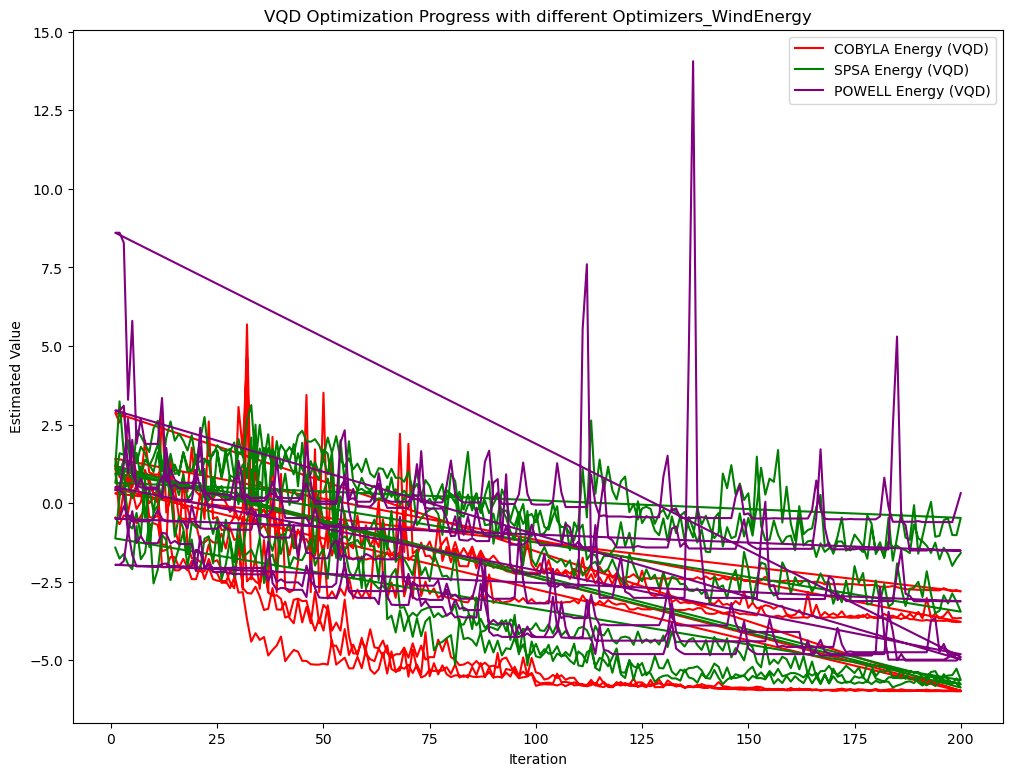


Maximum Value Details for Each Optimizer:
Optimizer: COBYLA
Maximum Eigenvalue: 5.688097554212684
Data Point:
{'v': 3.7, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}
--------------------------------------------------
Optimizer: SPSA
Maximum Eigenvalue: 7.5103642206425585
Data Point:
{'v': 3.2, 'H': 2.15, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.355}
--------------------------------------------------
Optimizer: POWELL
Maximum Eigenvalue: 25.55637634300061
Data Point:
{'v': 9.9, 'H': 2.6, 'L': 0.9188, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.429}
--------------------------------------------------


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms import VQD
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import *
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute

# Read CSV file containing values of v, H, L, D_outer, D_inner, and d
csv_file_path = "E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
v_values = data['v'].values
H_values = data['H'].values
L_values = data['L'].values
D_outer_values = data['D_outer'].values
D_inner_values = data['D_inner'].values
d_values = data['d'].values

# Constants
eta = 0.3  # Efficiency
E = 70 * 10**9  # Young's modulus in Pascal
rho = 1.225  # Air density in kg/m^3
pi = np.pi

# Objective Function for Wind Turbine Power Output
def wind_power_output(v, H, L, D_outer, D_inner, d):
    numerator = eta * ((rho**2) * (v**5) * (D_outer**2) * (((H - (L / 2))**2) * (L**3)))
    denominator = 12 * E * ((pi / 64) * ((D_outer**4) - (D_inner**4)) * d)
    power = numerator / denominator
    return power

# Define the expanded Pauli operator based on the wind turbine objective function
v_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 
H_operator = SparsePauliOp.from_list([("IZIII", 1)]) 
L_operator = SparsePauliOp.from_list([("IIZII", 1)]) 
D_outer_operator = SparsePauliOp.from_list([("IIIZI", 1)]) 
D_inner_operator = SparsePauliOp.from_list([("IIIIZ", 1)]) 
d_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 

# Define the initial interaction operator for wind turbine objective function
operator = v_operator + H_operator + L_operator + D_outer_operator + D_inner_operator + d_operator
sampler = Sampler()
fidelity = ComputeUncompute(sampler)  # Fidelity computation for the wind turbine system

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
options = Options(optimization_level=3)

# Define optimizers to use for wind turbine optimization
optimizers = {'COBYLA': COBYLA(), 'SPSA': SPSA(), 'POWELL': POWELL()}
iteration_data = {optimizer_name: {'counts': [], 'values': [], 'steps': []} for optimizer_name in optimizers.keys()}

# Callback function for tracking progress
# def callback(eval_count, params, value, meta, step, optimizer_name):
#     if eval_count <= 200:
#         iteration_data[optimizer_name]['counts'].append(eval_count)
#         iteration_data[optimizer_name]['values'].append(value)
#         iteration_data[optimizer_name]['steps'].append(step)
# Track maximum values and corresponding data points for each optimizer
max_values = {optimizer_name: -np.inf for optimizer_name in optimizers.keys()}
max_data_points = {optimizer_name: None for optimizer_name in optimizers.keys()}
max_eigenvalues = {optimizer_name: None for optimizer_name in optimizers.keys()}

# Modified callback function
def callback(eval_count, params, value, meta, step, optimizer_name):
    if value > max_values[optimizer_name]:
        max_values[optimizer_name] = value
        max_eigenvalues[optimizer_name] = value
        # Associate the data point from the CSV file for this optimizer's maximum eigenvalue
        index = eval_count % len(v_values)  # Assuming cyclic iteration through data points
        max_data_points[optimizer_name] = {
            "v": v_values[index],
            "H": H_values[index],
            "L": L_values[index],
            "D_outer": D_outer_values[index],
            "D_inner": D_inner_values[index],
            "d": d_values[index],
        }

    if eval_count <= 200:
        iteration_data[optimizer_name]['counts'].append(eval_count)
        iteration_data[optimizer_name]['values'].append(value)
        iteration_data[optimizer_name]['steps'].append(step)

def create_custom_ansatz(num_qubits, reps=3):
    parameters = [Parameter(f'θ_{i}') for i in range(2 * num_qubits * reps)]
    circuit = QuantumCircuit(num_qubits)
    
    param_idx = 0
    for _ in range(reps):
        # Add rotation layers
        for qubit in range(num_qubits):
            circuit.ry(parameters[param_idx], qubit)
            param_idx += 1
            circuit.rz(parameters[param_idx], qubit)
            param_idx += 1
        
        # Add entanglement layer with controlled-Z (cz) gates
        for qubit in range(num_qubits - 1):
            circuit.cz(qubit, qubit + 1)
        circuit.cz(num_qubits - 1, 0)  # Wrap-around entanglement for circular structure
        
    return circuit, parameters

def flatten_params(params):
    """Flatten a nested structure (list or dictionary) into a single list of values."""
    flat_list = []
    if isinstance(params, dict):
        for value in params.values():
            flat_list.extend(flatten_params(value))
    elif isinstance(params, list):
        for item in params:
            flat_list.extend(flatten_params(item))
    else:
        flat_list.append(params)
    return flat_list

def run_vqd_with_deflation(optimizer, optimizer_name, num_qubits=5, reps=3, num_states=3):
    # Create the custom ansatz and parameters
    ansatz_circuit, parameters = create_custom_ansatz(num_qubits, reps)
    
    estimator = Estimator()
    eigenvalues = []
    modified_operator = operator  # Start with the initial Hamiltonian
    
    for _ in range(num_states):
        # Create VQD instance
        vqd_instance = VQD(estimator=estimator, ansatz=ansatz_circuit, optimizer=optimizer, fidelity=fidelity,
                           callback=lambda eval_count, params, value, meta, step: callback(eval_count, params, value, meta, step, optimizer_name))
        
        # Compute current eigenvalue
        result = vqd_instance.compute_eigenvalues(modified_operator)
        eigenvalues.append(result.eigenvalues[0].real)  # Save the lowest eigenvalue
        
        # Retrieve and flatten optimized parameters
        optimized_params = result.optimal_parameters  # Retrieve optimized parameters
        
        # Fully flatten optimized_params and convert to floats
        optimized_params = flatten_params(optimized_params)
        optimized_params = [float(value) for value in optimized_params]
        
        # Create a parameter dictionary using individual Parameter instances
        param_dict = {param: value for param, value in zip(parameters, optimized_params)}
        
        # Bind optimized parameters directly to a new instance of the ansatz circuit
        eigenstate_circuit = ansatz_circuit.assign_parameters(param_dict)
        eigenstate = Statevector.from_instruction(eigenstate_circuit)  # Get the eigenstate from the circuit
        
        # Deflation term: calculate the outer product using the `to_operator` method
        deflation_term = SparsePauliOp.from_operator(eigenstate.to_operator())
        penalty_coefficient = 0.1  # Coefficient to control the strength of the deflation
        modified_operator = modified_operator + penalty_coefficient * deflation_term  # Add deflation term

    return eigenvalues
    
# Run VQD with Deflation for each optimizer
vqd_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqd_results[optimizer_name] = run_vqd_with_deflation(optimizer, optimizer_name)

# Plot results
colors = {'COBYLA': 'r', 'SPSA': 'g', 'POWELL': 'purple'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    counts = data['counts']
    values = data['values']
    plt.plot(counts, values, label=f'{optimizer_name} Energy (VQD)', color=colors[optimizer_name])

plt.xlabel('Iteration')
plt.ylabel('Estimated Value')
plt.title('VQD Optimization Progress with different Optimizers_WindEnergy')
plt.legend()
plt.savefig("vqd_optimization_progress_windturbine_deflation1BBB.svg", dpi=300)
plt.show()
# After all optimizations, print the maximum eigenvalue and corresponding data point for each optimizer
print("\nMaximum Value Details for Each Optimizer:")
for optimizer_name in optimizers.keys():
    print(f"Optimizer: {optimizer_name}")
    print(f"Maximum Eigenvalue: {max_eigenvalues[optimizer_name]}")
    print("Data Point:")
    print(max_data_points[optimizer_name])
    print("-" * 50)

C:\Users\sinha\AppData\Local\Temp\ipykernel_8348\3619647447.py:53: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\sinha\AppData\Local\Temp\ipykernel_8348\3619647447.py:135: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_8348\3619647447.py:135: DeprecationWarning: The class ``qiskit.primitives

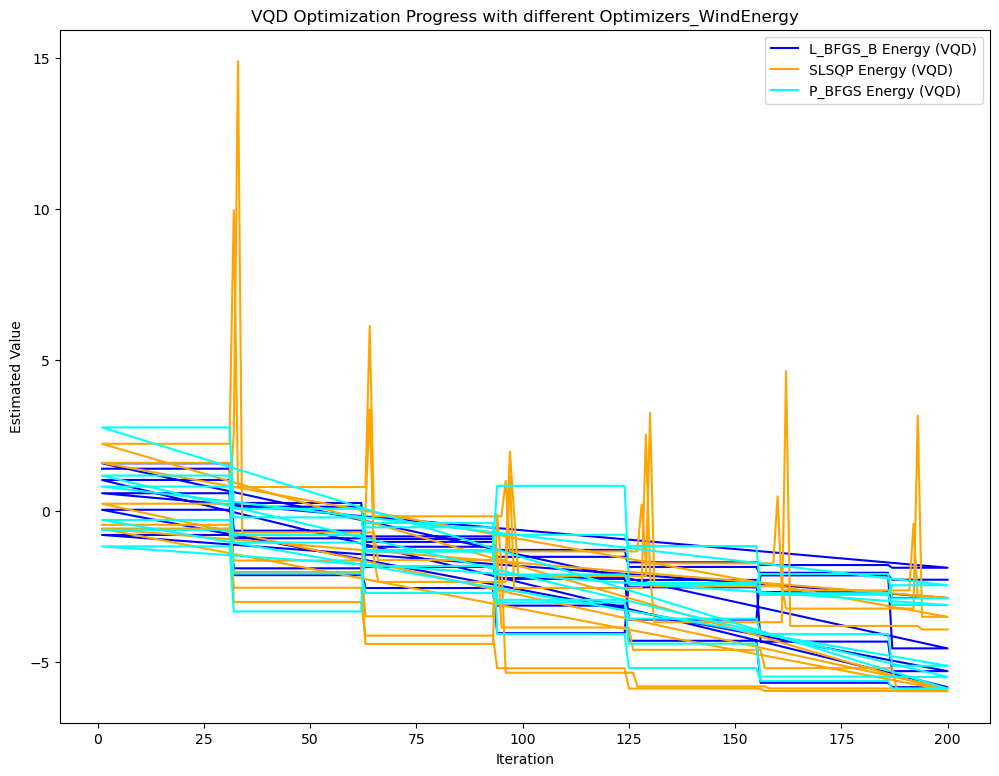


Maximum Value Details for Each Optimizer:
Optimizer: L_BFGS_B
Maximum Eigenvalue: 5.064063135931205
Data Point:
{'v': 10.6, 'H': 2.3, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.3795}
--------------------------------------------------
Optimizer: SLSQP
Maximum Eigenvalue: 14.878415293707327
Data Point:
{'v': 3.8, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}
--------------------------------------------------
Optimizer: P_BFGS
Maximum Eigenvalue: 2.756201997483668
Data Point:
{'v': 2.0, 'H': 2.0, 'L': 0.75, 'D_outer': 0.35, 'D_inner': 0.3, 'd': 0.33}
--------------------------------------------------


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms import VQD
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import L_BFGS_B, SLSQP, P_BFGS
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import *
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)


# Read CSV file containing values of v, H, L, D_outer, D_inner, and d
csv_file_path = "E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
v_values = data['v'].values
H_values = data['H'].values
L_values = data['L'].values
D_outer_values = data['D_outer'].values
D_inner_values = data['D_inner'].values
d_values = data['d'].values

# Constants
eta = 0.3  # Efficiency
E = 70 * 10**9  # Young's modulus in Pascal
rho = 1.225  # Air density in kg/m^3
pi = np.pi

# Objective Function for Wind Turbine Power Output
def wind_power_output(v, H, L, D_outer, D_inner, d):
    numerator = eta * ((rho**2) * (v**5) * (D_outer**2) * (((H - (L / 2))**2) * (L**3)))
    denominator = 12 * E * ((pi / 64) * ((D_outer**4) - (D_inner**4)) * d)
    power = numerator / denominator
    return power

# Define the expanded Pauli operator based on the wind turbine objective function
v_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 
H_operator = SparsePauliOp.from_list([("IZIII", 1)]) 
L_operator = SparsePauliOp.from_list([("IIZII", 1)]) 
D_outer_operator = SparsePauliOp.from_list([("IIIZI", 1)]) 
D_inner_operator = SparsePauliOp.from_list([("IIIIZ", 1)]) 
d_operator = SparsePauliOp.from_list([("ZIIII", 1)]) 

# Define the initial interaction operator for wind turbine objective function
operator = v_operator + H_operator + L_operator + D_outer_operator + D_inner_operator + d_operator
sampler = Sampler()
fidelity = ComputeUncompute(sampler)  # Fidelity computation for the wind turbine system

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
options = Options(optimization_level=3)

# Define optimizers to use for wind turbine optimization
optimizers = {'L_BFGS_B': L_BFGS_B(), 'SLSQP': SLSQP(), 'P_BFGS': P_BFGS()}
iteration_data = {optimizer_name: {'counts': [], 'values': [], 'steps': []} for optimizer_name in optimizers.keys()}

# Callback function for tracking progress
# def callback(eval_count, params, value, meta, step, optimizer_name):
#     if eval_count <= 200:
#         iteration_data[optimizer_name]['counts'].append(eval_count)
#         iteration_data[optimizer_name]['values'].append(value)
#         iteration_data[optimizer_name]['steps'].append(step)
# Track maximum value and corresponding data point
max_values = {optimizer_name: -np.inf for optimizer_name in optimizers.keys()}
max_data_points = {optimizer_name: None for optimizer_name in optimizers.keys()}
max_eigenvalues = {optimizer_name: None for optimizer_name in optimizers.keys()}

# Modified callback function
def callback(eval_count, params, value, meta, step, optimizer_name):
    if value > max_values[optimizer_name]:
        max_values[optimizer_name] = value
        max_eigenvalues[optimizer_name] = value
        # Associate the data point from the CSV file for this optimizer's maximum eigenvalue
        index = eval_count % len(v_values)  # Assuming cyclic iteration through data points
        max_data_points[optimizer_name] = {
            "v": v_values[index],
            "H": H_values[index],
            "L": L_values[index],
            "D_outer": D_outer_values[index],
            "D_inner": D_inner_values[index],
            "d": d_values[index],
        }

    if eval_count <= 200:
        iteration_data[optimizer_name]['counts'].append(eval_count)
        iteration_data[optimizer_name]['values'].append(value)
        iteration_data[optimizer_name]['steps'].append(step)
def create_custom_ansatz(num_qubits, reps=3):
    parameters = [Parameter(f'θ_{i}') for i in range(2 * num_qubits * reps)]
    circuit = QuantumCircuit(num_qubits)
    
    param_idx = 0
    for _ in range(reps):
        # Add rotation layers
        for qubit in range(num_qubits):
            circuit.ry(parameters[param_idx], qubit)
            param_idx += 1
            circuit.rz(parameters[param_idx], qubit)
            param_idx += 1
        
        # Add entanglement layer with controlled-Z (cz) gates
        for qubit in range(num_qubits - 1):
            circuit.cz(qubit, qubit + 1)
        circuit.cz(num_qubits - 1, 0)  # Wrap-around entanglement for circular structure
        
    return circuit, parameters

def flatten_params(params):
    """Flatten a nested structure (list or dictionary) into a single list of values."""
    flat_list = []
    if isinstance(params, dict):
        for value in params.values():
            flat_list.extend(flatten_params(value))
    elif isinstance(params, list):
        for item in params:
            flat_list.extend(flatten_params(item))
    else:
        flat_list.append(params)
    return flat_list

def run_vqd_with_deflation(optimizer, optimizer_name, num_qubits=5, reps=3, num_states=3):
    # Create the custom ansatz and parameters
    ansatz_circuit, parameters = create_custom_ansatz(num_qubits, reps)
    
    estimator = Estimator()
    eigenvalues = []
    modified_operator = operator  # Start with the initial Hamiltonian
    
    for _ in range(num_states):
        # Create VQD instance
        vqd_instance = VQD(estimator=estimator, ansatz=ansatz_circuit, optimizer=optimizer, fidelity=fidelity,
                           callback=lambda eval_count, params, value, meta, step: callback(eval_count, params, value, meta, step, optimizer_name))
        
        # Compute current eigenvalue
        result = vqd_instance.compute_eigenvalues(modified_operator)
        eigenvalues.append(result.eigenvalues[0].real)  # Save the lowest eigenvalue
        
        # Retrieve and flatten optimized parameters
        optimized_params = result.optimal_parameters  # Retrieve optimized parameters
        
        # Fully flatten optimized_params and convert to floats
        optimized_params = flatten_params(optimized_params)
        optimized_params = [float(value) for value in optimized_params]
        
        # Create a parameter dictionary using individual Parameter instances
        param_dict = {param: value for param, value in zip(parameters, optimized_params)}
        
        # Bind optimized parameters directly to a new instance of the ansatz circuit
        eigenstate_circuit = ansatz_circuit.assign_parameters(param_dict)
        eigenstate = Statevector.from_instruction(eigenstate_circuit)  # Get the eigenstate from the circuit
        
        # Deflation term: calculate the outer product using the `to_operator` method
        deflation_term = SparsePauliOp.from_operator(eigenstate.to_operator())
        penalty_coefficient = 0.1  # Coefficient to control the strength of the deflation
        modified_operator = modified_operator + penalty_coefficient * deflation_term  # Add deflation term

    return eigenvalues
    
# Run VQD with Deflation for each optimizer
vqd_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqd_results[optimizer_name] = run_vqd_with_deflation(optimizer, optimizer_name)

# Plot results
colors = {'L_BFGS_B': 'blue', 'SLSQP': 'orange', 'P_BFGS': 'cyan'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    counts = data['counts']
    values = data['values']
    plt.plot(counts, values, label=f'{optimizer_name} Energy (VQD)', color=colors[optimizer_name])

plt.xlabel('Iteration')
plt.ylabel('Estimated Value')
plt.title('VQD Optimization Progress with different Optimizers_WindEnergy')
plt.legend()
plt.savefig("vqd_optimization_progress_windturbine_deflation3BBccc.svg", dpi=300)
plt.show()
# After all optimizations, print the maximum eigenvalue and corresponding data point for each optimizer
print("\nMaximum Value Details for Each Optimizer:")
for optimizer_name in optimizers.keys():
    print(f"Optimizer: {optimizer_name}")
    print(f"Maximum Eigenvalue: {max_eigenvalues[optimizer_name]}")
    print("Data Point:")
    print(max_data_points[optimizer_name])
    print("-" * 50)